In [1]:
import xarray as xr
import os
import glob
import numpy as np
import warnings
import matplotlib.pyplot as plt
import sys

sys.path.append(os.path.abspath('../src-double-gyre'))
sys.path.append(os.path.abspath('../src'))
warnings.filterwarnings("ignore")
from helpers.collection_of_experiments import CollectionOfExperiments
from plot_helpers import *

%load_ext autoreload
%autoreload 3

In [2]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')

In [3]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2023/R4-sensitivity', additional_subfolder='output')

In [4]:
for RR in ['R4', 'R64', 'ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0']:
    ds.remesh(RR, 'R1')
    ds.remesh(RR, 'R2')
    if RR != 'R4':
        ds.remesh(RR, 'R4')

Experiment R4 coarsegrained to R1 is created. Its identificator=R4_R1
Experiment R4 coarsegrained to R2 is created. Its identificator=R4_R2
Experiment R64 coarsegrained to R1 is created. Its identificator=R64_R1
Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4
Experiment ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0 coarsegrained to R1 is created. Its identificator=ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0_R1
Experiment ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0 coarsegrained to R2 is created. Its identificator=ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0_R2
Experiment ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0 coarsegrained to R4 is created. Its identificator=ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0_R4


In [5]:
ds.remesh('R2', 'R1')

Experiment R2 coarsegrained to R1 is created. Its identificator=R2_R1


# Choosing the coarsest mesh possible for optimization problem
We choose coarse resolution 1 degree mostly to be prepared for global ocean model

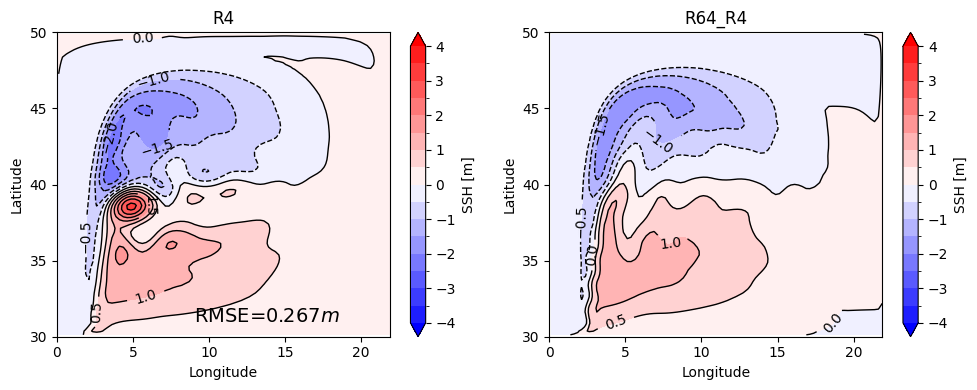

In [65]:
ds.plot_ssh(['R4', 'R64_R4'])

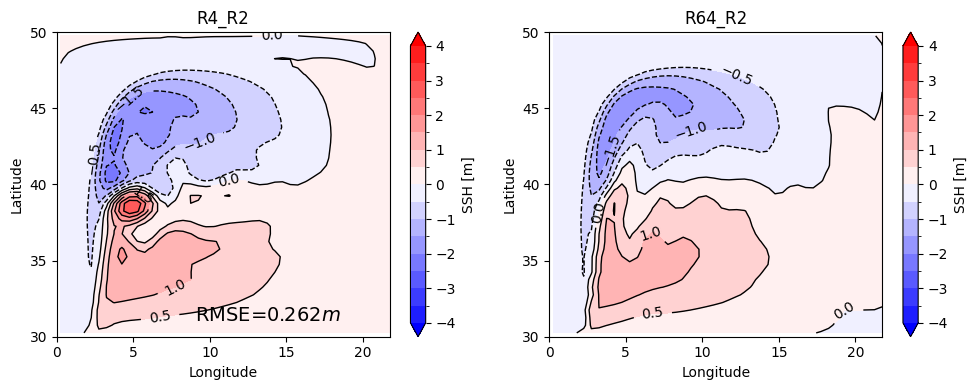

In [66]:
ds.plot_ssh(['R4_R2', 'R64_R2'])

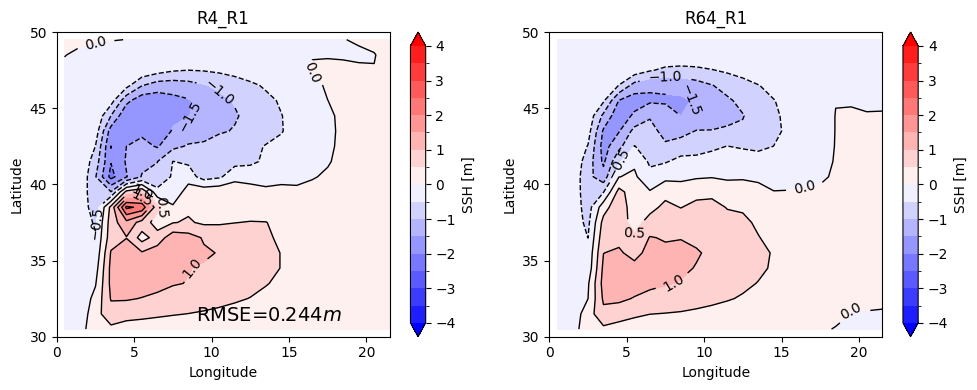

In [67]:
ds.plot_ssh(['R4_R1', 'R64_R1'])

In [114]:
ds['R4_R1'].ssh_mean.data.ravel().shape

(440,)

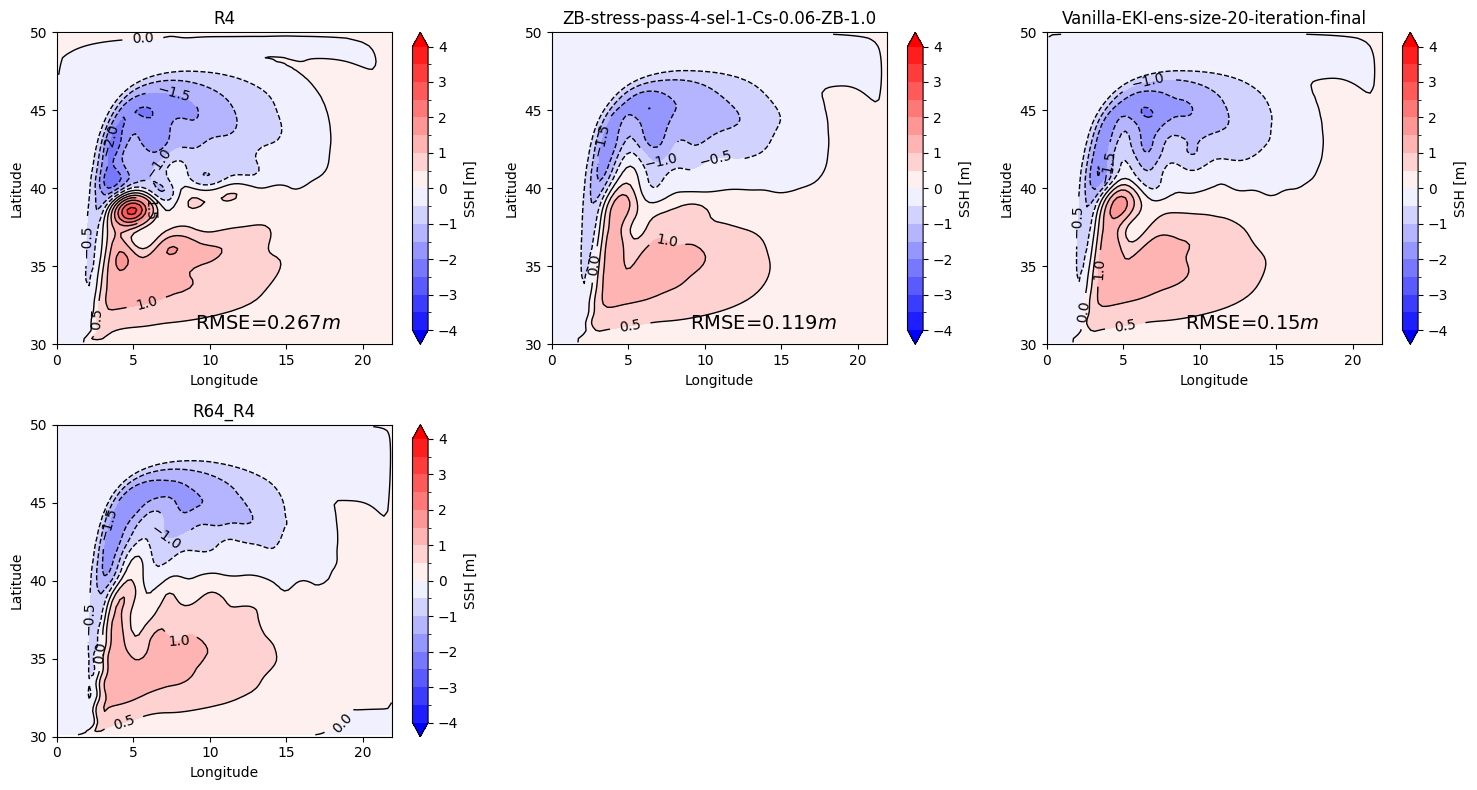

In [65]:
ds.plot_ssh(['R4', 'ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0', 'Vanilla-EKI-ens-size-20-iteration-final', 'R64_R4'])

# Compute error covariance matrix from internal variability of coarse and high-resolution models

In [99]:
Noise_variance = (ds['R4_R1'].ea.coarsen({'Time':60}, boundary='trim').mean()[1:].isel(zi=0).var('Time') + \
                 ds['R64_R1'].ea.coarsen({'Time':60}, boundary='trim').mean()[1:].isel(zi=0).var('Time')).compute()

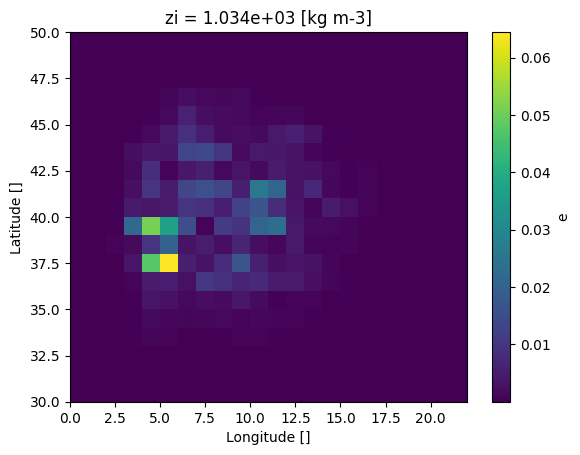

In [104]:
Noise_variance.plot()

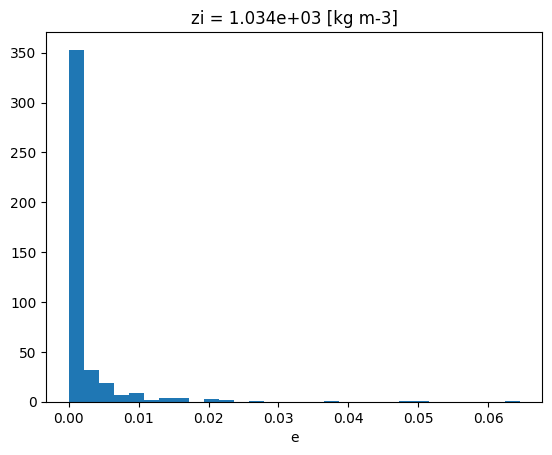

In [111]:
# For the first iteration, we do not want to provide a very accurate noise covariance matrix. Mostly because this would change the optimization objective which is different from our target (RMSE).
# We use noise variance 0.01 which holds most of the support of the variance distribution.
Noise_variance.plot.hist(bins=30);

# Justification of choosing time-averaging interval

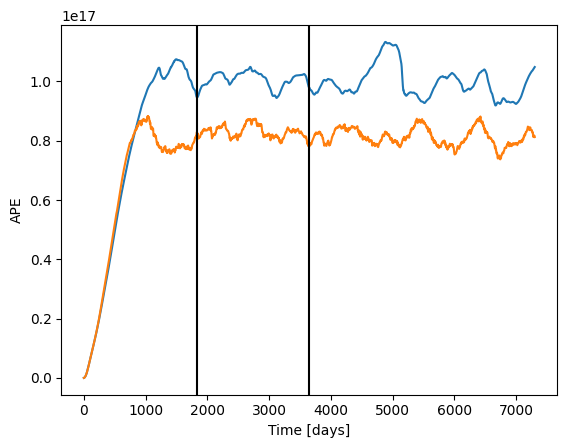

In [130]:
ds['R4'].series.APE.sum('Interface').plot()
ds['R64'].series.APE.sum('Interface').plot()
plt.axvline(x=365*5, color='k')
plt.axvline(x=365*10, color='k')

In [137]:
np.isnan(ds['R4'].ea[-1][0].coarsen({'xh':4, 'yh':4}).mean()).sum().compute()

<xarray.DataArray 'e' ()> Size: 8B
array(0)
Coordinates:
    Time     float64 8B 7.275e+03
    zi       float64 8B 1.034e+03

In [62]:
# Role of choosing the target
np.sqrt((((ds['R64_R1'].ea.coarsen({'Time':60}, boundary='trim').mean()[1] - ds['R64_R1'].ea.coarsen({'Time':60}, boundary='trim').mean()[1:].mean('Time')).isel(zi=0))**2).mean().compute())

<xarray.DataArray 'e' ()> Size: 4B
array(0.02700522, dtype=float32)
Coordinates:
    Time     float64 8B 2.7e+03
    zi       float64 8B 1.034e+03

# Optimizing variabiltiy
We are interested in three types of metrics:
* Interface STD
* EKE spectrum in two laeyrs
* PDF of velocity

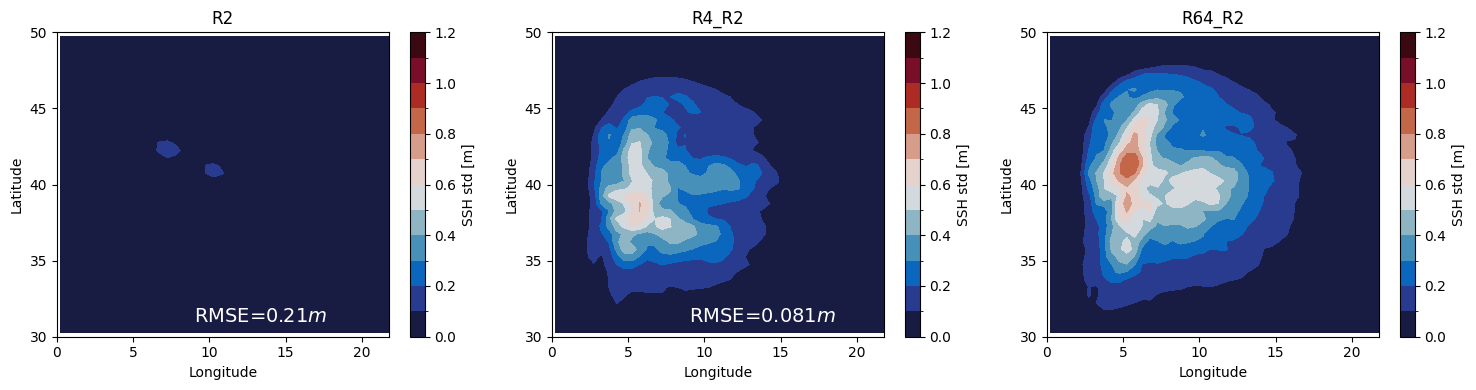

In [8]:
ds.plot_ssh_std(['R2', 'R4_R2', 'R64_R2'])

In [10]:
# Note. It might be better to compute SSH STD on the 1/2-degree grid, but coarsen it to 1 degree grid for simpler solving of inverse problem.

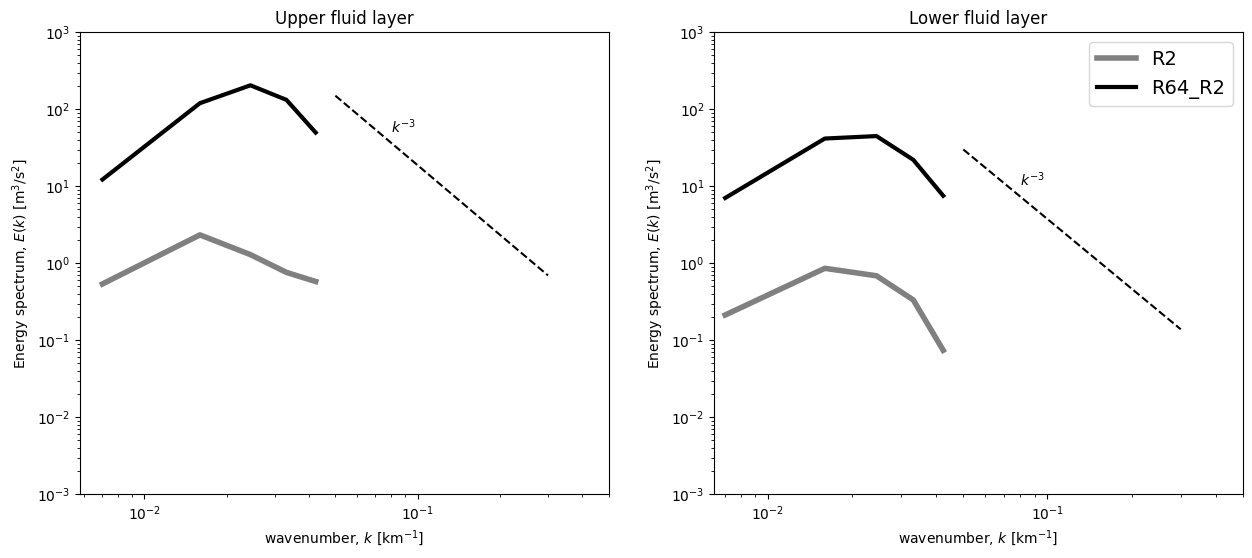

In [24]:
ds.plot_KE_spectrum(['R2', 'R64_R2'])

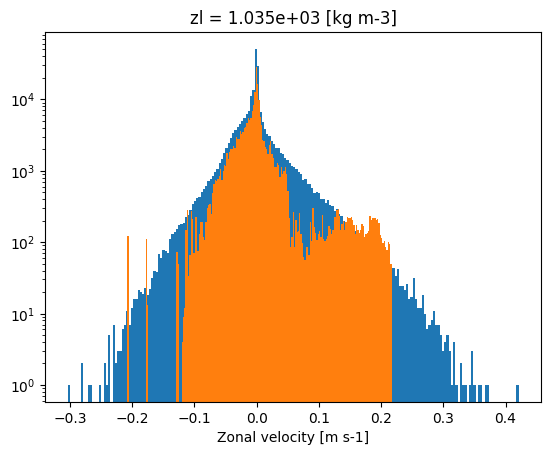

In [45]:
ds['R64_R2'].u.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
ds['R2'].u.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
plt.yscale('log')

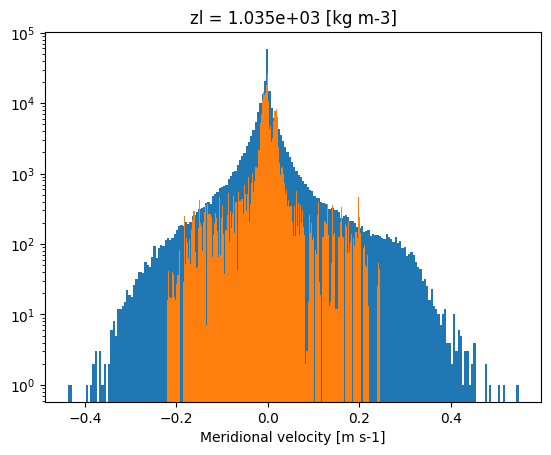

In [46]:
ds['R64_R2'].v.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
ds['R2'].v.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
plt.yscale('log')

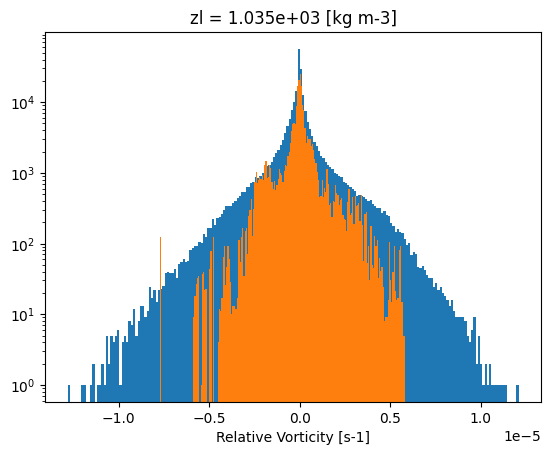

In [47]:
ds['R64_R2'].RV.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
ds['R2'].RV.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
plt.yscale('log')

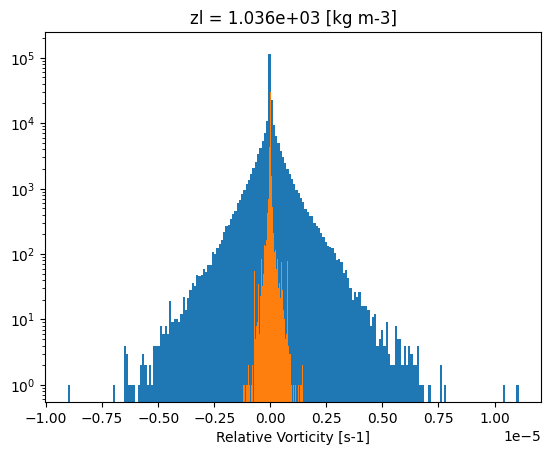

In [48]:
ds['R64_R2'].RV.sel(Time=slice(365*10,None)).isel(zl=1).plot.hist(bins=200);
ds['R2'].RV.sel(Time=slice(365*10,None)).isel(zl=1).plot.hist(bins=200);
plt.yscale('log')

## PDFs already at 1/4 resolution are pretty accurate. And so, using them for optimization might be tricky.

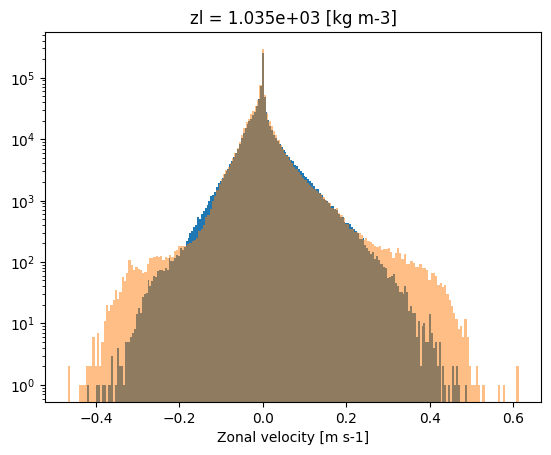

In [51]:
ds['R64_R4'].u.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
ds['R4'].u.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200, alpha=0.5);
plt.yscale('log')

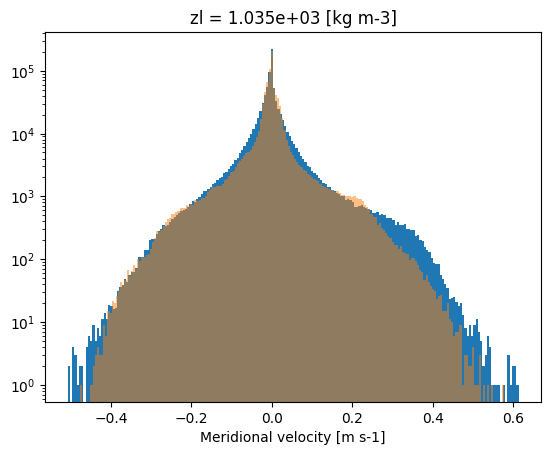

In [52]:
ds['R64_R4'].v.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
ds['R4'].v.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200, alpha=0.5);
plt.yscale('log')

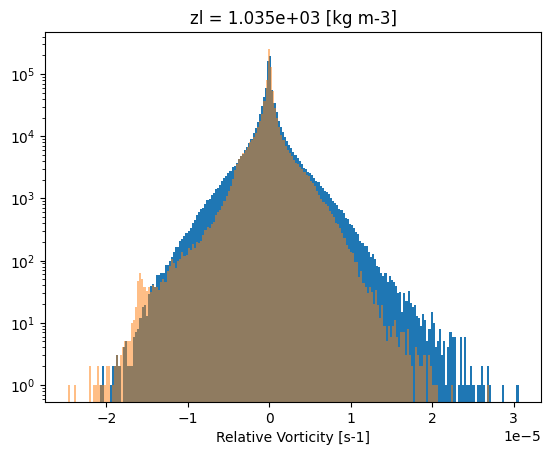

In [53]:
# PDFs 
ds['R64_R4'].RV.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200);
ds['R4'].RV.sel(Time=slice(365*10,None)).isel(zl=0).plot.hist(bins=200, alpha=0.5);
plt.yscale('log')

# Check metrics function

In [6]:
import sys
sys.path.append('../scripts')
from loss_DG import variability_metrics

In [19]:
R2 = variability_metrics(ds['R2'].e, ds['R2'].u, ds['R2'].v, ds['R2'].param, coarse_factor=4)

In [20]:
R64 = variability_metrics(ds['R64_R2'].e, ds['R64_R2'].u, ds['R64_R2'].v, ds['R64_R2'].param, coarse_factor=4)

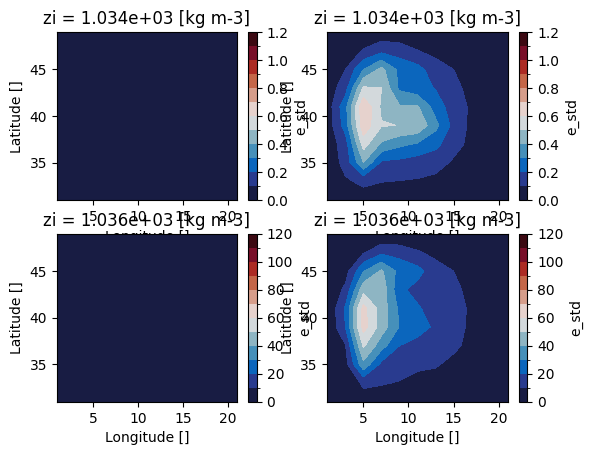

In [22]:
plt.subplot(2,2,1)
R2['e_std'][0].plot.contourf(levels=np.arange(0,1.3,0.1), cmap=cmocean.cm.balance)

plt.subplot(2,2,2)
R64['e_std'][0].plot.contourf(levels=np.arange(0,1.3,0.1), cmap=cmocean.cm.balance)

plt.subplot(2,2,3)
R2['e_std'][1].plot.contourf(levels=np.arange(0,130,10), cmap=cmocean.cm.balance)

plt.subplot(2,2,4)
R64['e_std'][1].plot.contourf(levels=np.arange(0,130,10), cmap=cmocean.cm.balance)

(6.418853424874073e-06, 0.0005)

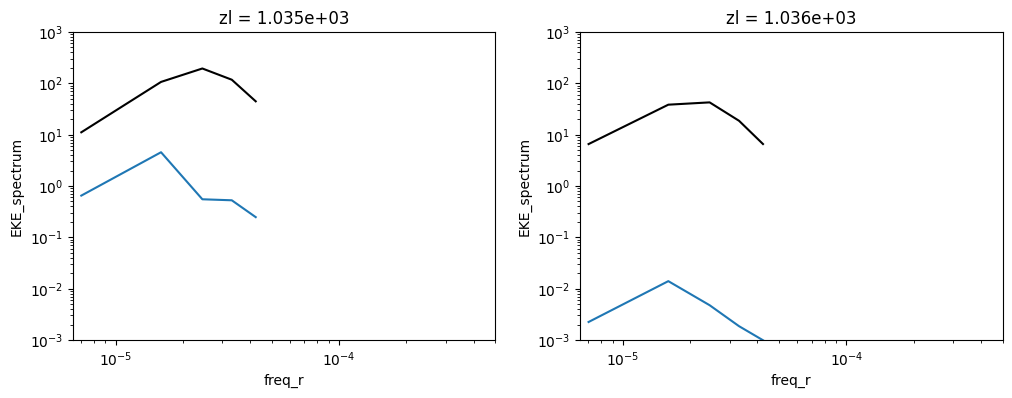

In [23]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
R2['EKE_spectrum'][0].plot()
R64['EKE_spectrum'][0].plot(color='k')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-3,1e+3])
plt.xlim([None,0.5e-3])

plt.subplot(1,2,2)
R2['EKE_spectrum'][1].plot()
R64['EKE_spectrum'][1].plot(color='k')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-3,1e+3])
plt.xlim([None,0.5e-3])

# Observation error

In [24]:
R64_0 = variability_metrics(ds['R64_R2'].e, ds['R64_R2'].u, ds['R64_R2'].v, ds['R64_R2'].param, Time=slice(1825,3650), coarse_factor=4)
R64_1 = variability_metrics(ds['R64_R2'].e, ds['R64_R2'].u, ds['R64_R2'].v, ds['R64_R2'].param, Time=slice(3650,5475), coarse_factor=4)
R64_2 = variability_metrics(ds['R64_R2'].e, ds['R64_R2'].u, ds['R64_R2'].v, ds['R64_R2'].param, Time=slice(5475,7300), coarse_factor=4)

In [25]:
e_std_var = xr.concat([R64_0['e_std'], R64_1['e_std'], R64_2['e_std']], dim='segment').var('segment')
EKE_spectrum_var = xr.concat([R64_0['EKE_spectrum'],R64_1['EKE_spectrum'], R64_2['EKE_spectrum']], dim='segment').var('segment')

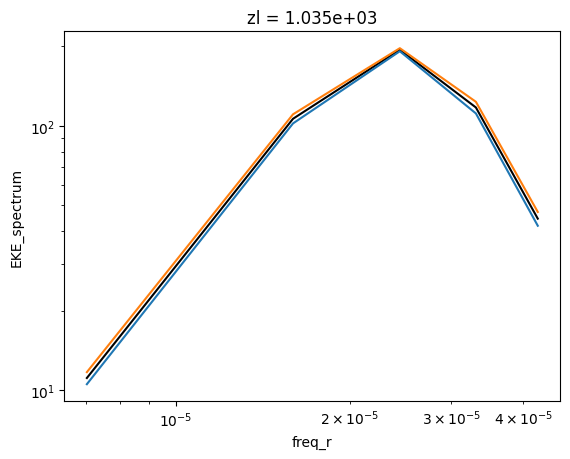

In [26]:
R64_0['EKE_spectrum'][0].plot(color='k')
(R64_0['EKE_spectrum'][0] - np.sqrt(EKE_spectrum_var[0])).plot()
(R64_0['EKE_spectrum'][0] + np.sqrt(EKE_spectrum_var[0])).plot()
plt.yscale('log')
plt.xscale('log')

In [27]:
EKE_spectrum_var[0]

<xarray.DataArray 'EKE_spectrum' (freq_r: 5)> Size: 40B
array([ 0.33985339, 17.89558811,  6.78024862, 35.55310603,  7.1509498 ])
Coordinates:
    zl       float64 8B 1.035e+03
  * freq_r   (freq_r) float64 40B 7.022e-06 1.597e-05 ... 3.31e-05 4.235e-05

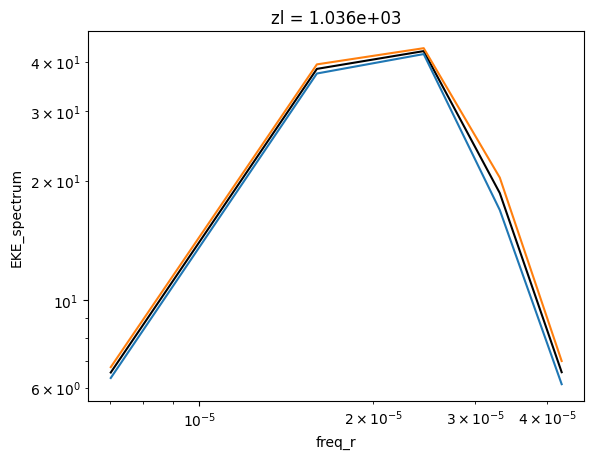

In [28]:
R64_0['EKE_spectrum'][1].plot(color='k')
(R64_0['EKE_spectrum'][1] - np.sqrt(EKE_spectrum_var[1])).plot()
(R64_0['EKE_spectrum'][1] + np.sqrt(EKE_spectrum_var[1])).plot()
plt.yscale('log')
plt.xscale('log')

In [29]:
EKE_spectrum_var[1]

<xarray.DataArray 'EKE_spectrum' (freq_r: 5)> Size: 40B
array([0.04264486, 1.03651566, 0.53089214, 3.06576357, 0.19500905])
Coordinates:
    zl       float64 8B 1.036e+03
  * freq_r   (freq_r) float64 40B 7.022e-06 1.597e-05 ... 3.31e-05 4.235e-05

In [30]:
R64_dataset = xr.Dataset()
R64_dataset['e_std'] = R64_0['e_std']
R64_dataset['EKE_spectrum'] = R64_0['EKE_spectrum']
R64_dataset['e_std_var'] = e_std_var
R64_dataset['EKE_spectrum_var'] = EKE_spectrum_var

# Weighting
We want to minimize an analog of mean-squared error.
Using error covariance matrices for e_std and EKE_spectrum
allows to adjust the weight according to different physical 
dimensionality and different scale of perturbations in different layers 
However, a typical objective in EKI is ||Gamma^{-1/2} (y - G(u))||_2^2, which
is dominated by the metrics which have more points (i.e., e_std).
Thus, we would like to rescale both y and Gamma such that the resulting error
is MSE-like but not Summed squared error.

Let's first try to renormalize the vector $y$ only:
$$
\widehat{y} = y / \sqrt{N},
$$
$$
\widehat{G}(u) = G(u) / \sqrt{N}
$$
where $N$ is the number of grid points. Then
$$
||\Gamma^{-1/2} (\widehat{y} - \widehat{G}(u))||_2^2 = (\widehat{y} - \widehat{G}(u))^T \Gamma^{-1} (\widehat{y} - \widehat{G}(u)) = \frac{1}{N} (y - G(u))^T \Gamma^{-1} (y - G(u)) = \frac{1}{N} ||\Gamma^{-1/2} (y - G(u))||_2^2,
$$
which is a proper covariance-weighted MSE.

Based on this observation, we will weight each field with $1/\sqrt{N}$ where $N$ is the number of grid points for each field.

In [31]:
R64_dataset.e_std[0].values.size

110

In [32]:
R64_dataset.EKE_spectrum[0].size

5

In [33]:
R64_dataset['e_std_weight'] = 1 / np.sqrt(R64_dataset.e_std[0].values.size)
R64_dataset['EKE_spectrum_weight'] = 1 / np.sqrt(R64_dataset.EKE_spectrum[0].size)

In [34]:
R64_dataset.astype('float32').to_netcdf('/home/pp2681/calibration/scripts/R64_R2/variability-2-degrees.nc')

# Analysis of the parameter's convergence

In [184]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/Vanilla-EKI-ens-size-20/metrics.nc')

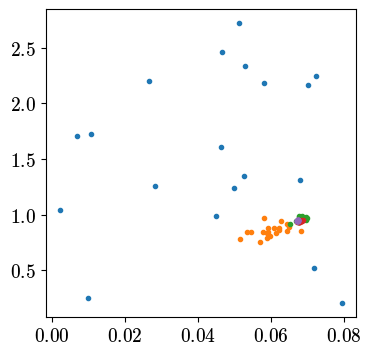

In [185]:
for iter in range(5):
    plt.plot(metrics.Cs[iter], metrics.ZB[iter], '.')

In [186]:
rmse_train = np.sqrt(((metrics.ssh_coarse - metrics.ssh_fine)**2).mean(['yh', 'xh']))
rmse_mean_train = np.sqrt(((metrics.ssh_coarse.mean('ens') - metrics.ssh_fine)**2).mean(['yh', 'xh'])) # Metric used by Dunbar
rmse_mean_test = np.sqrt(((metrics.ssh_coarse.mean('ens') - ds['R64_R1'].ssh_mean)**2).mean(['yh', 'xh']))

Text(0.5, 1.0, '')

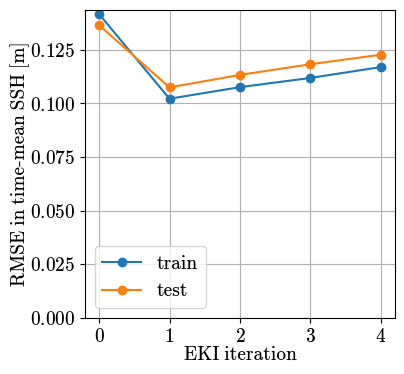

In [187]:
rmse_mean_train.plot(marker='o', label='train')
rmse_mean_test.plot(marker='o', label='test')
plt.legend()
plt.ylim([0,None])
plt.grid()
plt.ylabel('RMSE in time-mean SSH [m]')
plt.xlabel('EKI iteration')
plt.xticks(np.arange(0,5));
plt.title('')

# Animation of particles on the loss landscape

In [5]:
from helpers.computational_tools import Lk_error
def error_ssh(exp):
    return Lk_error(ds[exp].ssh_mean,ds['R64_R4'].ssh_mean)[0]

In [6]:
from functools import cache
@cache
def error_2d(error_function = error_ssh, prefix='ZB-clean'):
    ZBs = sorted([float(exp.split('-')[-1]) for exp in ds.exps if f'{prefix}-Cs-0.03' in exp])
    Css = sorted(set([float(exp.split('-')[-3]) for exp in ds.exps if f'{prefix}-Cs-' in exp]))
    
    error = np.zeros((len(ZBs), len(Css)))
    for i, Cs in enumerate(Css):
        for j, ZB in enumerate(ZBs):
            try:
                error[j,i] = error_function(f'{prefix}-Cs-{Cs:.2f}-ZB-{ZB}')
            except:
                error[j,i] = np.nan
    error = xr.DataArray(error, dims=['ZB', 'Cs'], coords={'Cs': Css, 'ZB': ZBs})
    return error

In [7]:
error_ssh('ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0')

0.118933715

In [8]:
ssh = {'v0': 0.26709399, 'vmin': 0.0, 'error_function': error_ssh, 
           'cbar_ticks': np.arange(0.0,0.7,0.05), 
           'cbar_extend': 'neither', 'cbar_label': 'RMSE in \ntime-mean SSH, $\mathrm{m}$'};

In [9]:
def plot_panels(exps, labels, v0, vmin, error_function, color='w', cbar_ticks=None, cbar_extend='none', cbar_label=''):
    vmin=0.00; vmax=0.3

    for col in range(len(exps)):
        label=labels[col]
        exp=exps[col]
        e = error_2d(error_function = error_function, prefix=exp)
        X,Y = np.meshgrid(e.Cs, e.ZB)
        em = np.ma.masked_invalid(e)
        im = plt.pcolor(X,Y,em,vmin=vmin,vmax=vmax,cmap='RdBu_r')
        # https://stackoverflow.com/questions/35905393/python-leave-numpy-nan-values-from-matplotlib-heatmap-and-its-legend
        plt.gca().patch.set(hatch='OO', edgecolor='black')
        
        cb = plt.colorbar(im, fraction=0.3, pad=0.05, aspect=15, ticks=cbar_ticks, extend=cbar_extend)
        cb.set_label('RMSE [m]', fontsize=16, labelpad=10)
        if col<len(exps)-1:
            cb.ax.set_yticklabels(['']*len(cbar_ticks))
            cb.set_label('')
        
        plt.xticks(e.Cs.values, rotation=60)
        if len(e.ZB) > 16:
            plt.yticks(e.ZB.values[::2])
        else:
            plt.yticks(e.ZB.values)
            
        plt.xlabel('')
        if col==0:
            plt.ylabel('ZB scaling coefficient, $\gamma$', fontsize=20)
        else:
            plt.ylabel('')
        plt.title('ZB20-Smooth')
        plt.xlabel('Smagorinsky coefficient $C_S$', ha='center', fontsize=16)
    

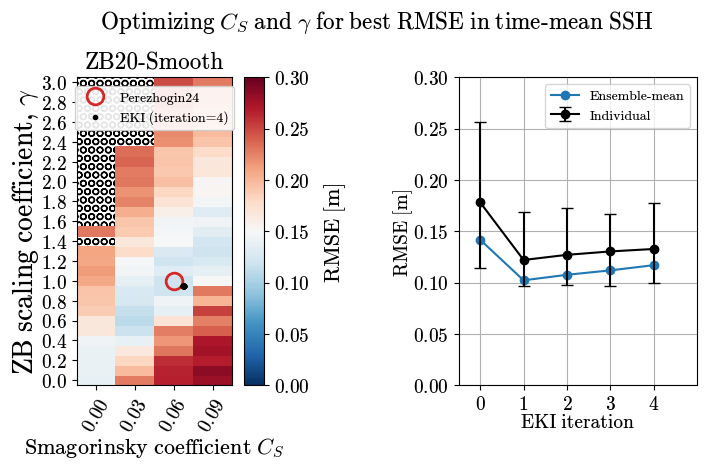

In [11]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/Vanilla-EKI-ens-size-20/metrics.nc')
def plot(iteration=0, metrics=metrics):
    default_rcParams({'axes.formatter.limits': (-3,3), 'figure.subplot.wspace': 0.6})
    fig = plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plot_panels(['ZB-stress-pass-4-sel-1'], ['ZB20-Smooth'], **ssh)
    plt.plot(0.06,1.0,color='tab:red', marker='o', markerfacecolor='none', markeredgewidth=2, markersize=12, label='Perezhogin24', ls='')

    plt.plot(metrics.Cs[iteration], metrics.ZB[iteration], '.', color='k', label=f'EKI (iteration={iteration})')
    plt.legend(bbox_to_anchor=(0.5,0.9), loc='center', framealpha=0.9, fontsize=10)

    plt.subplot(1,2,2)
    rmse_train = np.sqrt(((metrics.ssh_coarse - metrics.ssh_fine)**2).mean(['yh', 'xh']))
    rmse_mean_train = np.sqrt(((metrics.ssh_coarse.mean('ens') - metrics.ssh_fine)**2).mean(['yh', 'xh'])) # Metric used by Dunbar
    plt.plot(np.arange(iteration+1), rmse_mean_train[:iteration+1], marker='o', label='Ensemble-mean')
    #plt.plot(np.arange(iteration+1), rmse_mean_test[:iteration+1], marker='o', label='Ensemble-mean (10y)')
    plt.title('')
    plt.ylabel('RMSE [m]')
    plt.ylim([0.00,0.3])
    plt.xticks(np.arange(5))
    plt.xlim([-0.5,5])
    plt.grid()
    plt.xlabel('EKI iteration')
    ymin = rmse_train.min('ens')[:iteration+1]
    ymax = rmse_train.max('ens')[:iteration+1]
    ymid = rmse_train.mean('ens')[:iteration+1]

    yerr = np.vstack([ymid - ymin, ymax - ymid])
    plt.errorbar(np.arange(iteration+1), ymid, yerr=yerr, fmt='o', capsize=4, color='k', label='Individual', ls='-')
    plt.legend(fontsize=10)
    
    plt.suptitle('Optimizing $C_S$ and $\gamma$ for best RMSE in time-mean SSH', y=1.05)
plot(4)

In [317]:
create_animation_ffmpeg(plot, np.arange(5), filename='Double-Gyre-EKI.mp4', FPS=1)

Frames already exists in folder .ffmpeg/Double-Gyre-EKI


Do you want to update snapshots?: [y/n] y


Savefig .ffmpeg/Double-Gyre-EKI/frame-0.png
Savefig .ffmpeg/Double-Gyre-EKI/frame-1.png86
Savefig .ffmpeg/Double-Gyre-EKI/frame-2.png4
Savefig .ffmpeg/Double-Gyre-EKI/frame-3.png86
Savefig .ffmpeg/Double-Gyre-EKI/frame-4.png74
Native resolution of snapshots is used: 1406x934

Animation Double-Gyre-EKI.mp4 at FPS=1 will last for 5.0 seconds. The frames are saved to 
.ffmpeg/Double-Gyre-EKI

Running the command:
cd /home/pp2681/calibration/notebooks; ffmpeg -y -framerate 1 -i .ffmpeg/Double-Gyre-EKI/frame-%d.png -s:v 1406x934 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p Double-Gyre-EKI.mp4


ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

# Sensitivity to EKI algorithms

Text(0.5, 1.05, 'Vanilla EKI')

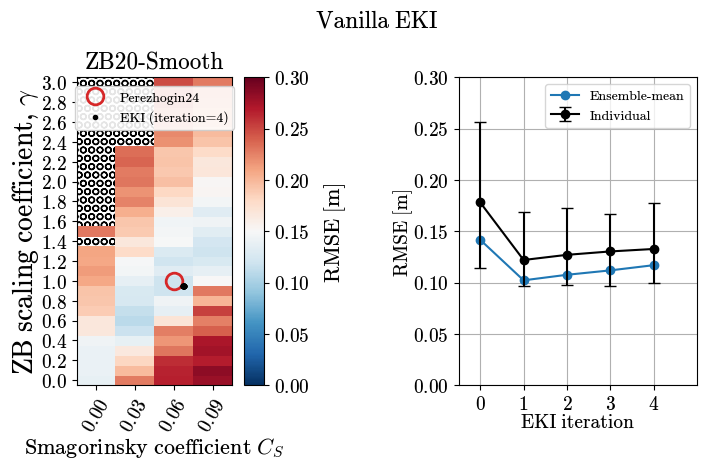

In [25]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/Vanilla-EKI-ens-size-20/metrics.nc')
plot(4,metrics)
plt.suptitle("Vanilla EKI", y=1.05)

Text(0.5, 1.05, 'Vanilla EKI different seed')

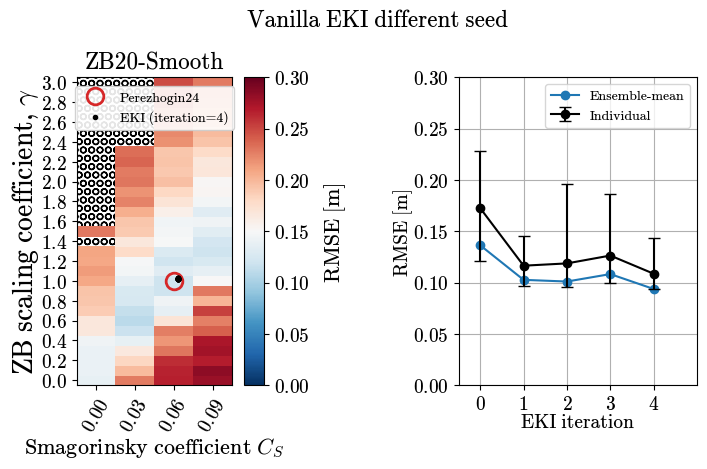

In [24]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/Vanilla-EKI-ens-size-20-seed/metrics.nc')
plot(4,metrics)
plt.suptitle("Vanilla EKI different seed", y=1.05)

Text(0.5, 1.05, 'Vanilla EKI bigger ensemble')

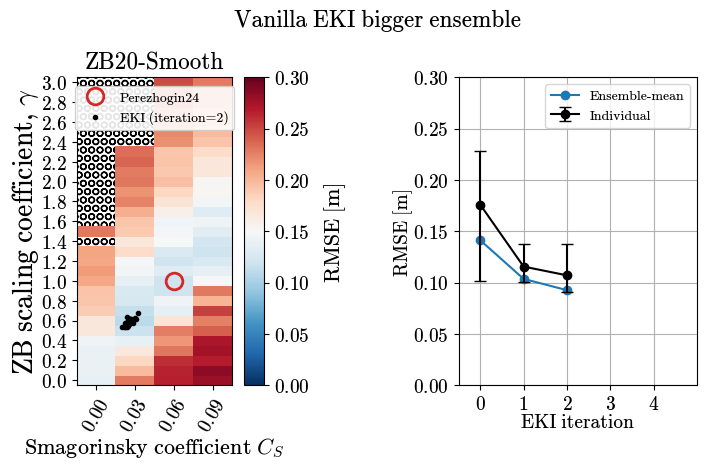

In [31]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/Vanilla-EKI-ens-size-40/metrics.nc')
plot(2,metrics)
plt.suptitle("Vanilla EKI bigger ensemble", y=1.05)

Text(0.5, 1.05, 'SECNice EKI')

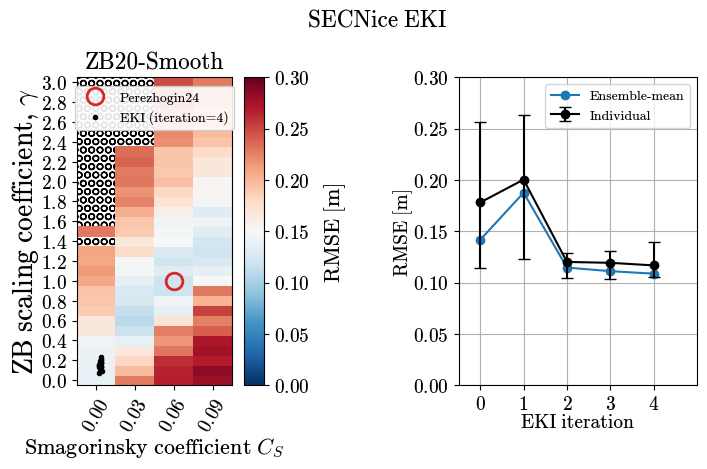

In [38]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/SECNice-EKI-ens-size-20/metrics.nc')
plot(4,metrics)
plt.suptitle("SECNice EKI", y=1.05)

Text(0.5, 1.05, 'Data-Misfit-Controller EKI')

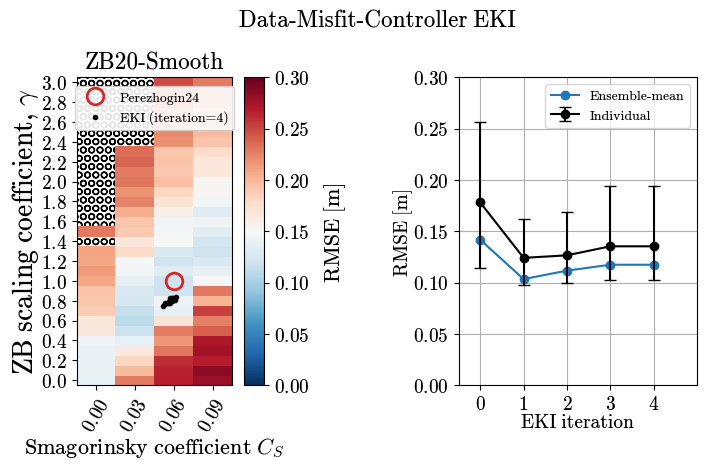

In [44]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/MFC-EKI-ens-size-20/metrics.nc')
plot(4,metrics)
plt.suptitle("Data-Misfit-Controller EKI", y=1.05)

Text(0.5, 1.05, 'Data-Misfit-Controller+SECNice+Nesterov EKI')

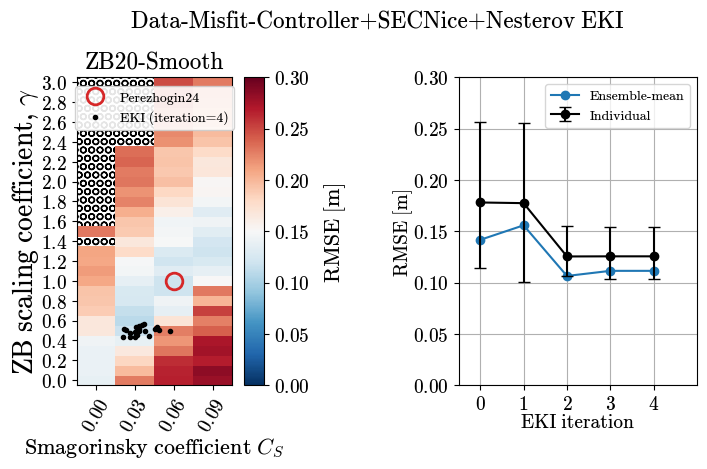

In [49]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/ALL-EKI-ens-size-20/metrics.nc')
plot(4,metrics)
plt.suptitle("Data-Misfit-Controller+SECNice+Nesterov EKI", y=1.05)

Text(0.5, 1.05, 'Randomized-Likelihood EKI')

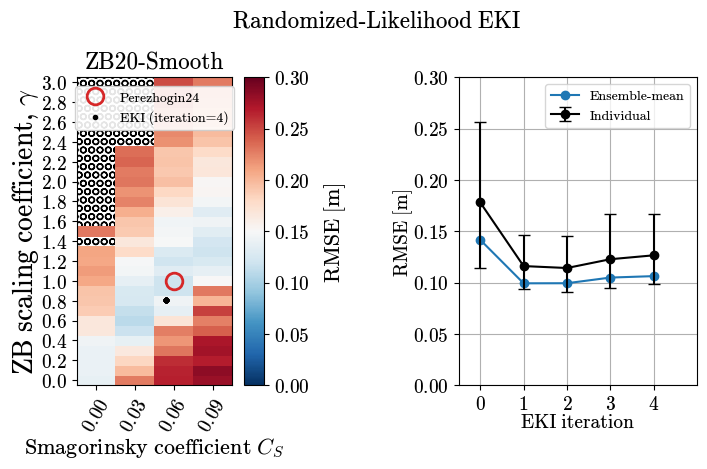

In [54]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/RL-EKI-ens-size-20/metrics.nc')
plot(4,metrics)
plt.suptitle("Randomized-Likelihood EKI", y=1.05)

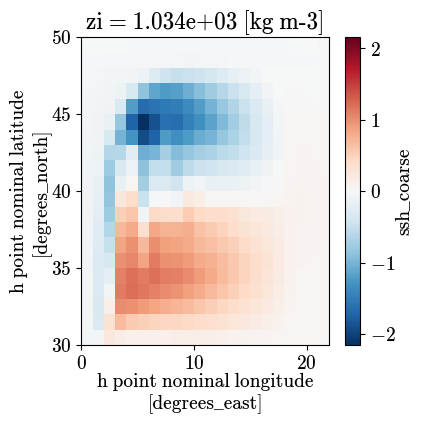

In [79]:
metrics.ssh_coarse[0][8].plot()

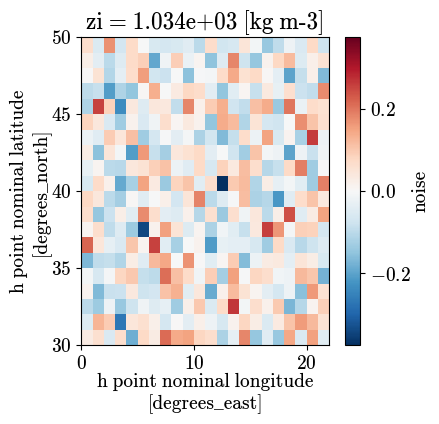

In [65]:
metrics.noise[8].plot()

# Emulate stage

In [12]:
metrics = xr.open_dataset('/scratch/pp2681/mom6/Apr2023/R4-sensitivity/Vanilla-EKI-ens-size-20/metrics.nc')

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

# X: (100, 2) input points
# Ys: (100, 440) output values for each GP
X = np.stack([metrics.Cs.stack(z=('iter','ens')), metrics.ZB.stack(z=('iter','ens'))],-1)
Ys = metrics.ssh_coarse.stack(z=('iter','ens')).stack(t=['yh', 'xh']).values

# Remove exploded experiments
X = np.delete(X, 18, axis=0)
Ys = np.delete(Ys, 18, axis=0)

# Train GPs to predict each spatial grid point
gps = []
for i in range(440):
    #print(f'{i} spatial coordinate')
    y = Ys[:, i]
    kernel = C(1.0, (1e-1, 1e1)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e1)) \
           + WhiteKernel(noise_level=1e-1, noise_level_bounds=(1e-3, 1e1))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
    gp.fit(X, y)
    gps.append(gp)

In [15]:
# Train GP to predict RMSE only
Y_mse = np.mean((Ys - metrics.ssh_fine.stack(t=['yh', 'xh']).values)**2, -1)
kernel = C(1.0, (1e-5, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) \
           + WhiteKernel(noise_level=1e-1, noise_level_bounds=(1e-5, 1e5))
gp_mse = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp_mse.fit(X, Y_mse)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.1),
                         n_restarts_optimizer=5, normalize_y=True)

# Compute Likelihood as a function of inputs

In [16]:
def likelihood(Cs, ZB, gps, gp_mse, yobs):
    '''
    Cs and ZB are 1d arrays or scalars
    '''
    _X, _Y = np.meshgrid(Cs, ZB)
    X_test = np.stack([_X.ravel(), _Y.ravel()],-1)

    Y_mean = []
    Y_std = []
    for gp in gps:
        y_mean, y_std = gp.predict(X_test, return_std=True)
        Y_mean.append(y_mean)
        Y_std.append(y_std)
    
    Y_mean = np.stack(Y_mean, axis=1)
    Y_std = np.stack(Y_std, axis=1)

    logLK =  - 0.5 * (((Y_mean - yobs)**2) / (Y_std**2)).sum(-1) - \
               0.5 * np.sum(np.log(2 * np.pi * (Y_std**2)), -1)
            
    LK = np.exp(logLK)

    RMSE = np.sqrt(np.mean((Y_mean - yobs)**2, -1))
    
    RMSE_stupid = np.sqrt(gp_mse.predict(X_test, return_std=False))
    
    return _X, _Y, Y_mean, Y_std, LK, logLK, RMSE, RMSE_stupid

Text(0.5, 1.0, 'Emulator std')

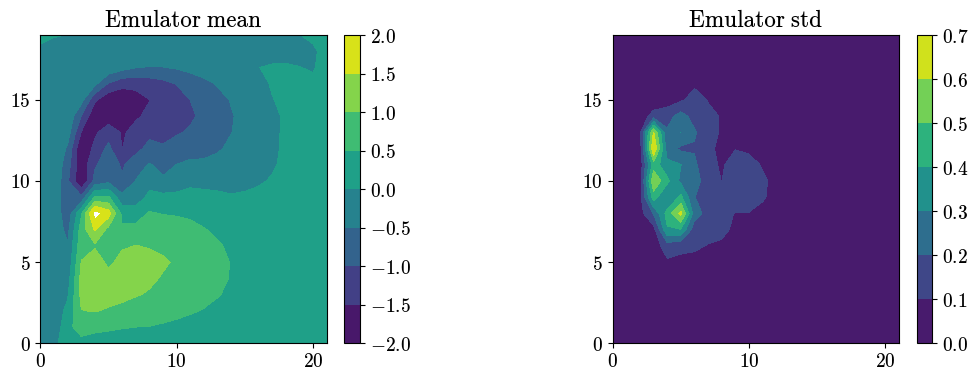

In [17]:
_X, _Y, Y_mean, Y_std, LK, logLK, RMSE, RMSE_stupid = likelihood([0.06],[0.0],gps,gp_mse,metrics.ssh_fine.values.ravel())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.contourf(Y_mean.reshape([20,22]), levels=np.arange(-2,2.5,0.5))
plt.colorbar()
plt.title('Emulator mean')

plt.subplot(1,2,2)
plt.contourf(Y_std.reshape([20,22]))
plt.colorbar()
plt.title('Emulator std')

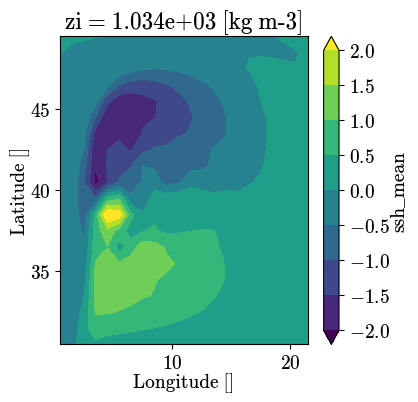

In [134]:
ds['R4_R1'].ssh_mean.plot.contourf(vmin=-2, vmax=1.6, cmap='viridis', levels=np.arange(-2,2.5,0.5))
#ds['ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0_R1'].ssh_mean.plot.contourf(vmin=-2, vmax=1.6, cmap='viridis', levels=np.arange(-2,2.5,0.5))

In [19]:
# im = plt.contourf(_X,_Y,logLK.reshape(100,100))
# plt.colorbar(im)

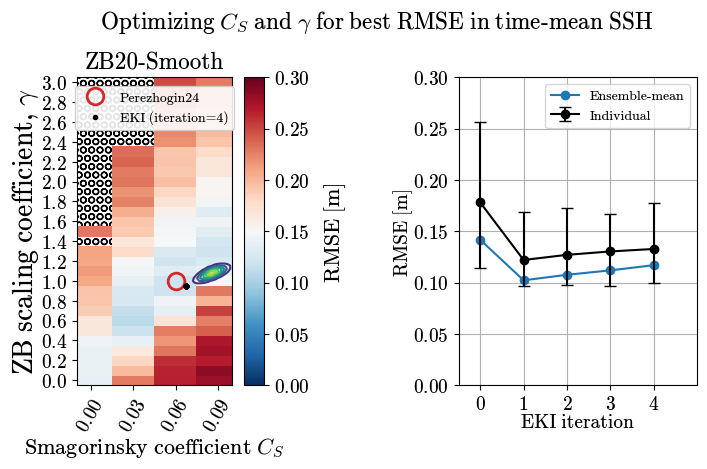

In [202]:
def plot(iteration=0):
    default_rcParams({'axes.formatter.limits': (-3,3), 'figure.subplot.wspace': 0.6})
    fig = plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plot_panels(['ZB-stress-pass-4-sel-1'], ['ZB20-Smooth'], **ssh)
    plt.plot(0.06,1.0,color='tab:red', marker='o', markerfacecolor='none', markeredgewidth=2, markersize=12, label='Perezhogin24', ls='')

    plt.plot(metrics.Cs[iteration], metrics.ZB[iteration], '.', color='k', label=f'EKI (iteration={iteration})')
    plt.contour(_X,_Y,LK.reshape(100,100), label='posterior')
    plt.xlim([-0.01, 0.1])

    plt.legend(bbox_to_anchor=(0.5,0.9), loc='center', framealpha=0.9, fontsize=10)


    plt.subplot(1,2,2)
    plt.plot(np.arange(iteration+1), rmse_mean_train[:iteration+1], marker='o', label='Ensemble-mean')
    #plt.plot(np.arange(iteration+1), rmse_mean_test[:iteration+1], marker='o', label='Ensemble-mean (10y)')
    plt.title('')
    plt.ylabel('RMSE [m]')
    plt.ylim([0.00,0.3])
    plt.xticks(np.arange(5))
    plt.xlim([-0.5,5])
    plt.grid()
    plt.xlabel('EKI iteration')
    ymin = rmse_train.min('ens')[:iteration+1]
    ymax = rmse_train.max('ens')[:iteration+1]
    ymid = rmse_train.mean('ens')[:iteration+1]

    yerr = np.vstack([ymid - ymin, ymax - ymid])
    plt.errorbar(np.arange(iteration+1), ymid, yerr=yerr, fmt='o', capsize=4, color='k', label='Individual', ls='-')
    plt.legend(fontsize=10)
    
    plt.suptitle('Optimizing $C_S$ and $\gamma$ for best RMSE in time-mean SSH', y=1.05)
plot(4)

# Emulate SSH or its MSE (EKI dataset)? 

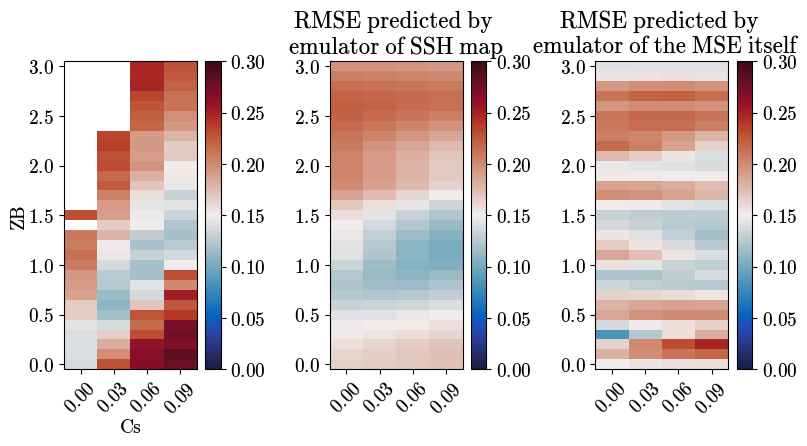

In [29]:
_X, _Y, Y_mean, Y_std, LK, logLK, RMSE, RMSE_stupid = likelihood([0.0,0.03,0.06,0.09],np.arange(0.0,3.1,0.1),gps,gp_mse,metrics.ssh_fine.values.ravel())

fig = plt.figure(figsize=(9,4))
plt.subplot(1,3,1)
error_2d(error_ssh, 'ZB-stress-pass-4-sel-1').plot(vmin=0, vmax=0.3, cmap=cmocean.cm.balance)
plt.xticks([0,0.03,0.06,0.09], rotation=45);

plt.subplot(1,3,2)
plt.pcolormesh(_X,_Y,RMSE.reshape(31,4), vmin=0, vmax=0.3, cmap=cmocean.cm.balance)
plt.colorbar()
plt.title('RMSE predicted by \nemulator of SSH map')
plt.xticks([0,0.03,0.06,0.09], rotation=45);

plt.subplot(1,3,3)
plt.pcolormesh(_X,_Y,RMSE_stupid.reshape(31,4), vmin=0, vmax=0.3, cmap=cmocean.cm.balance)
plt.colorbar()
plt.title('RMSE predicted by \n emulator of the MSE itself')
plt.xticks([0,0.03,0.06,0.09], rotation=45);

# Emulate SSH or its MSE (grid-search dataset)?

In [37]:
prefix = 'ZB-stress-pass-4-sel-1'
ZBs = sorted([float(exp.split('-')[-1]) for exp in ds.exps if f'{prefix}-Cs-0.03' in exp])
Css = sorted(set([float(exp.split('-')[-3]) for exp in ds.exps if f'{prefix}-Cs-' in exp]))

metrics = xr.Dataset()
metrics['ssh_fine'] = ds['R64'].ssh_mean.coarsen({'xh':64, 'yh':64}).mean().compute()
metrics['ssh_coarse'] = xr.DataArray(np.nan * np.zeros((len(Css), len(ZBs), 20, 22)), dims=['Cs', 'ZB', 'yh', 'xh'], coords={'Cs': Css, 'ZB': ZBs})

for i, Cs in enumerate(Css):
    for j, ZB in enumerate(ZBs):
        try:
            metrics['ssh_coarse'][i,j] = ds[f'{prefix}-Cs-{Cs:.2f}-ZB-{ZB}'].ssh_mean.coarsen({'xh':4, 'yh':4}).mean().compute()
        except:
            pass

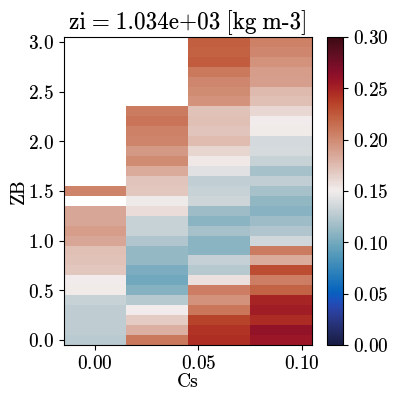

In [48]:
np.sqrt(((metrics.ssh_coarse - metrics.ssh_fine)**2).mean(['yh', 'xh'])).plot(vmin=0, vmax=0.3, cmap=cmocean.cm.balance, x='Cs')

In [229]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C, Matern

# X: (124, 2) input points
# Ys: (124, 440) output values for each GP
_X, _Y = np.meshgrid(metrics.Cs, metrics.ZB)
X = np.stack([_X.ravel(), _Y.ravel()],-1)
Ys = metrics.ssh_coarse.stack(z=(['ZB', 'Cs'])).stack(t=['yh', 'xh']).values

# Remove exploded experiments
mask = ~np.any(np.isnan(Ys), axis=1)
X = X[mask]
Ys = Ys[mask]

In [232]:
# Train GPs to predict each spatial grid point
gps = []
for i in range(440):
    #print(f'{i} spatial coordinate')
    y = Ys[:, i]
    kernel = C(1.0, (1e-1, 1e1)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e1)) \
            + WhiteKernel(noise_level=1e-1) # Typical noise level we know from EKI studies
           #+ WhiteKernel(noise_level=1e-1, noise_level_bounds=(1e-3, 1e1))
            
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
    gp.fit(X, y)
    gps.append(gp)

In [233]:
# Train GP to predict MSE directly
Y_mse = np.mean((Ys - metrics.ssh_fine.stack(t=['yh', 'xh']).values)**2, -1)
kernel = C(1.0, (1e-1, 1e1)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e1)) \
         + WhiteKernel(noise_level=1e-2) # Same noise level as for SSH emulator
         #+ WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+10))
gp_mse = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp_mse.fit(X, Y_mse)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=5, normalize_y=True)

Text(0.5, 1.0, 'Emulator std')

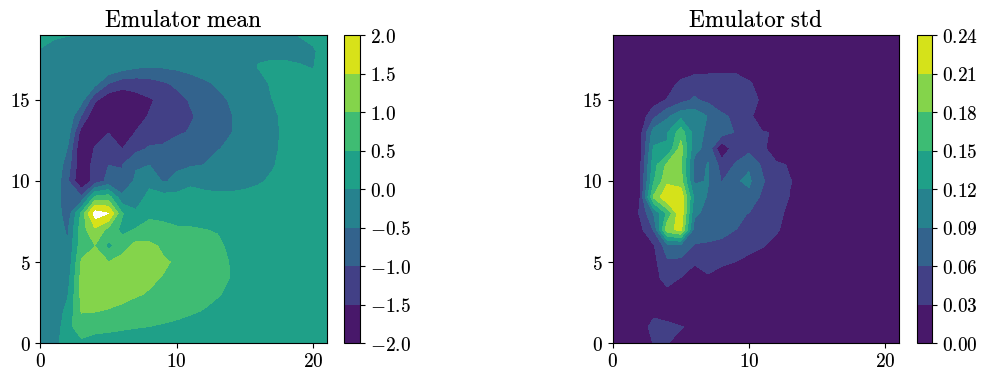

In [234]:
_X, _Y, Y_mean, Y_std, LK, logLK, RMSE, RMSE_stupid = likelihood([0.06],[0.0],gps,gp_mse,metrics.ssh_fine.values.ravel())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.contourf(Y_mean.reshape([20,22]), levels=np.arange(-2,2.5,0.5))
plt.colorbar()
plt.title('Emulator mean')

plt.subplot(1,2,2)
plt.contourf(Y_std.reshape([20,22]))
plt.colorbar()
plt.title('Emulator std')

In [235]:
_X, _Y, Y_mean, Y_std, LK, logLK, RMSE, RMSE_stupid = likelihood([0.0,0.03,0.06,0.09],np.arange(0.0,3.1,0.1),gps,gp_mse,metrics.ssh_fine.values.ravel())

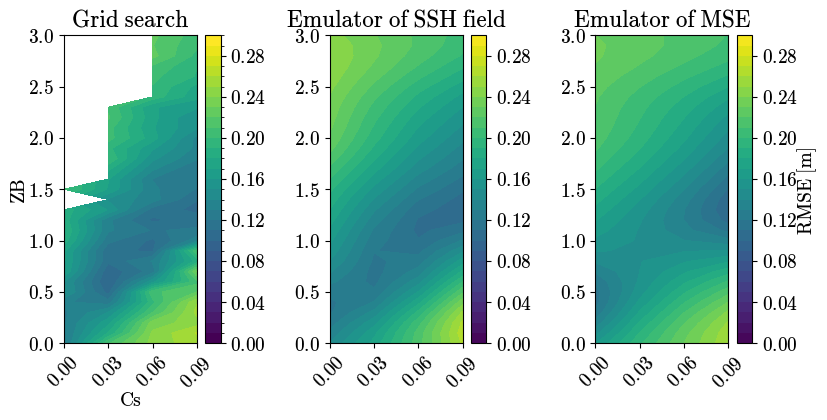

In [236]:
_X, _Y, Y_mean, Y_std, LK, logLK, RMSE, RMSE_stupid = likelihood([0.0,0.03,0.06,0.09],np.arange(0.0,3.1,0.1),gps,gp_mse,metrics.ssh_fine.values.ravel())

RMSE_grid = np.sqrt(((metrics.ssh_coarse - metrics.ssh_fine)**2).mean(['yh', 'xh']))

fig = plt.figure(figsize=(9,4))
plt.subplot(1,3,1)
RMSE_grid.plot.contourf(vmin=0, vmax=0.3, cmap='viridis', x='Cs', levels=np.arange(0.0,0.301,0.01))
plt.xticks([0,0.03,0.06,0.09], rotation=45);
plt.title('Grid search')

plt.subplot(1,3,2)
plt.contourf(_X,_Y,RMSE.reshape(31,4), vmin=0, vmax=0.3, cmap='viridis', levels=np.arange(0.0,0.301,0.01))
plt.colorbar()
plt.title('Emulator of SSH field')
plt.xticks([0,0.03,0.06,0.09], rotation=45);

plt.subplot(1,3,3)
plt.contourf(_X,_Y,RMSE_stupid.reshape(31,4), vmin=0, vmax=0.3, cmap='viridis', levels=np.arange(0.0,0.301,0.01))
plt.colorbar(label='RMSE [m]')
plt.title('Emulator of MSE')
plt.xticks([0,0.03,0.06,0.09], rotation=45);

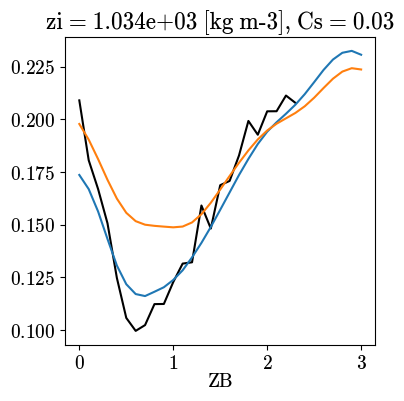

In [237]:
RMSE_grid[1].plot(color='k')
plt.plot(RMSE_grid.ZB, RMSE.reshape(31,4)[:,1])
plt.plot(RMSE_grid.ZB, RMSE_stupid.reshape(31,4)[:,1])

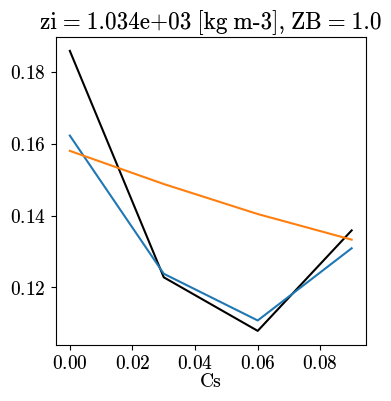

In [238]:
RMSE_grid[:,10].plot(color='k')
plt.plot(RMSE_grid.Cs, RMSE.reshape(31,4)[10,:])
plt.plot(RMSE_grid.Cs, RMSE_stupid.reshape(31,4)[10,:])

# Check variability code

In [68]:
import os
import sys
sys.path.append('../scripts')
import numpy as np
import xarray as xr
from slurm_DG import *
from loss_DG import *
import argparse

In [69]:
TAG = 'init'
hpc = HPC.add(name=TAG, time=2, begin='1minute', executable='/scratch/pp2681/MOM6-examples/build/compiled_executables/MOM6-dev-m2lines-Aug18')
base_path = '/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/variability-R2'
optimization_folder = 'EKI-SECNice-Nesterov-100-spread-0.25'
# Here, we attenuate the spread of the initial ensemble as if not doing so, experiments explode
ENS_SPREAD = 0.25

In [77]:
# Model configuration
ANN_params = PARAMETERS.add(**configuration('R2')).add(DAYMAX=3650.0).add(USE_ZB2020='True',ZB2020_USE_ANN='True',ZB2020_ANN_FILE_TALL='INPUT/Tall.nc',USE_CIRCULATION_IN_HORVISC='True')
# Read necessary NETCDF files
ANN_netcdf_default = xr.open_dataset('/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subfilter/FGR3/EXP1/model/Tall.nc').drop_vars(['x_test', 'y_test'])
# Read observation vector
observation = xr.open_dataset('/home/pp2681/calibration/scripts/R64_R2/variability.nc')

# EKI configuration
N_iterations = 5
N_ensemble = 100

# Initial ensemble for EKI
A1_mean = ANN_netcdf_default['A1'].values.reshape(-1)
b1_mean = ANN_netcdf_default['b1'].values.reshape(-1)
A1_std = ENS_SPREAD * ANN_netcdf_default['A1'].values.std()
b1_std = ENS_SPREAD * ANN_netcdf_default['b1'].values.std()

np.random.seed(0)
# 63 x 100 matrix
# Where 63 is the number of free parameters and 100 is the ensemble size
# Note: we do computations here in float64, but later convert to float32 for online experiments
initial_ensemble = np.concatenate([A1_mean, b1_mean]).reshape(-1,1) + np.concatenate([A1_std * np.random.randn(len(A1_mean), N_ensemble), b1_std * np.random.randn(len(b1_mean), N_ensemble)]).astype('float64')

# Observation vector for EKI
# 10 values of EKE spectrum
y = (observation.EKE_spectrum).values.ravel().astype('float64')

# Observation (+forward model) covariance matrix
# Vector 2 numbers
EKE_spectrum_var = observation.EKE_spectrum_var.mean(['freq_r']).compute().values
# [var_0, var_1] becomes [var_0, var_0, var_0, var_0, var_0, var_1 var_1 var_1 var_1 var_1]
Gamma = 2. * np.diag(np.repeat(EKE_spectrum_var, 5).astype('float64'))

In [79]:
from julia import Main

Main.eval("""
    using EnsembleKalmanProcesses, Random        
    Random.seed!(2)   # Fix random numbers globally
    """)

Main.y = y
Main.Γ = Gamma
Main.initial_ensemble = initial_ensemble

Main.eval("""
    eki = EnsembleKalmanProcess(
    initial_ensemble, y, Γ, Inversion(),
    scheduler = DefaultScheduler(1),
    verbose=true)
    """)

os.makedirs(f'{base_path}/{optimization_folder}', exist_ok=True)

In [80]:
metrics = xr.Dataset()
nzl = 2
nfreq_r = 5
metrics['EKE_spectrum'] = xr.DataArray(np.nan * np.zeros([N_iterations, N_ensemble, nzl, nfreq_r]), dims=['iter', 'ens', 'zl', 'freq_r'])
metrics['param'] = xr.DataArray(np.nan * np.zeros([N_iterations, N_ensemble, 63]), dims=['iter', 'ens', 'pdim'])

In [81]:
iteration=0
params = Main.eval("get_u_final(eki)")
iteration_path = f'{base_path}/{optimization_folder}/iteration-{iteration:02d}'
params_file = f'{iteration_path}-params.txt'

print('Params mean-ref/std', params.mean(-1) - np.concatenate([A1_mean, b1_mean]), '/', params.std(-1))

if not(os.path.exists(params_file)):
    print('Saving parameters to file', params_file)
    np.savetxt(params_file, params)
else:
    params_old = np.loadtxt(params_file)
    if not(np.allclose(params, params_old)):
        print('Parameters changed! Check the optimization algorithm.')
        sys.exit(1)   # terminate immediately with error code
    else:
        print('Parameters are the same. Keep going...')

Params mean-ref/std [ 2.15583896e-03  2.95623849e-03 -2.13508530e-03 -7.09373156e-03
 -4.52889563e-04 -7.31484750e-03 -4.86439264e-03 -4.45525819e-03
 -1.01646554e-03  5.90736586e-03 -1.03418189e-04  7.02985200e-03
 -8.02697460e-05  1.15137814e-04 -1.69912658e-03  2.09105573e-03
  2.34706989e-03 -2.38580107e-03 -3.55753559e-03  1.15139628e-03
  2.28700658e-03 -4.92227499e-03 -2.60369063e-03 -1.62865591e-03
  1.56999555e-03 -2.89365079e-03  1.59814635e-05 -4.18108879e-03
  6.78078241e-04 -6.78754221e-03 -3.53521383e-03 -1.10442292e-03
 -7.98387466e-04 -2.81101247e-03  1.48127314e-03  3.38974640e-03
 -2.74052547e-04 -1.05954612e-03 -4.11768039e-04 -1.70466208e-03
 -2.66044512e-03 -1.12405456e-03 -2.93282998e-03  5.89587715e-03
 -4.01439498e-04  5.37024668e-04  1.81598876e-03 -1.25422426e-04
  2.93154298e-03  6.22176675e-03 -2.81138739e-03 -4.15261685e-03
 -3.39819533e-04  1.85367502e-03  1.52009015e-03 -6.40144452e-03
  6.41796465e-03  2.78612973e-04  9.61234784e-05 -3.32913716e-03
  3.3

In [82]:
%%time
if os.path.exists(iteration_path):
    print('Folder with experiments exists')
    g_ens = np.zeros([10, N_ensemble]).astype('float64')
    for ens_member, param in enumerate(params.T):
        try:
            ds = xr.open_mfdataset(f'{iteration_path}/ens-member-{ens_member:02d}/output/prog_*.nc', decode_times=False)
            static = xr.open_mfdataset(f'{iteration_path}/ens-member-{ens_member:02d}/output/ocean_geometry.nc', decode_times=False).rename({'lonh': 'xh', 'lath': 'yh'})
            data = variability_metrics(ds.e, ds.u, ds.v, static)
            
            g_ens[:,ens_member] = (data.EKE_spectrum).values.ravel().astype('float64')
            print(f'Ensemble member {ens_member} succesfully ingested')

            metrics['EKE_spectrum'][iteration][ens_member] = data.EKE_spectrum
        except:
            # Experiment is not ready or exploded or runtime error
            g_ens[:,ens_member] = np.nan
            print(f'Ensemble member {ens_member} failed. Filled with NaNs')
        # Save parameter even if simulation exploded
        metrics['param'][iteration][ens_member] = param

Folder with experiments exists
Ensemble member 0 failed. Filled with NaNs
Ensemble member 1 succesfully ingested
Ensemble member 2 succesfully ingested
Ensemble member 3 succesfully ingested
Ensemble member 4 succesfully ingested
Ensemble member 5 succesfully ingested
Ensemble member 6 succesfully ingested
Ensemble member 7 succesfully ingested
Ensemble member 8 succesfully ingested
Ensemble member 9 succesfully ingested
Ensemble member 10 succesfully ingested
Ensemble member 11 succesfully ingested
Ensemble member 12 succesfully ingested
Ensemble member 13 succesfully ingested
Ensemble member 14 succesfully ingested
Ensemble member 15 failed. Filled with NaNs
Ensemble member 16 succesfully ingested
Ensemble member 17 succesfully ingested
Ensemble member 18 succesfully ingested
Ensemble member 19 succesfully ingested
Ensemble member 20 succesfully ingested
Ensemble member 21 succesfully ingested
Ensemble member 22 succesfully ingested
Ensemble member 23 succesfully ingested
Ensemble me

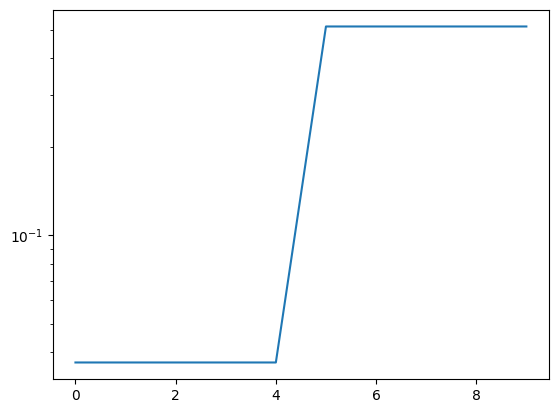

In [85]:
import matplotlib.pyplot as plt
plt.plot(np.diag(np.linalg.inv(Gamma)))
plt.yscale('log')

In [86]:
Main.g_ens = g_ens

In [87]:
Main.eval("update_ensemble!(eki, g_ens, deterministic_forward_map=false)")

In [88]:
params = Main.eval("get_u_final(eki)")

In [95]:
params.mean(-1)

array([ 0.00208785, -0.02890732,  0.35415935,  0.35525158,  0.17361422,
        0.1481224 , -0.003734  ,  0.16966829, -0.02409214,  0.17490204,
        0.07548753,  0.10369601, -0.02684156,  0.39476127, -0.00785814,
       -0.01843253, -0.01535485,  0.1303538 ,  0.36596636,  0.17604063,
        0.1414694 ,  0.01572073,  0.34213378, -0.00340183, -0.04093913,
       -0.0293198 ,  0.1705143 , -0.02549714, -0.02648049,  0.17180502,
       -0.06645832, -0.11782071, -0.08086214, -0.2712317 ,  0.17647135,
        0.09382237, -0.23415328,  0.07534418,  0.12986843, -0.09519228,
       -0.06577126,  0.11239732,  0.00453533,  0.16849233, -0.01600901,
       -0.2439643 ,  0.16153217,  0.10519571,  0.02930129, -0.0982335 ,
       -0.07730527,  0.23764656,  0.15385992,  0.11818485, -0.01606998,
       -0.01014639,  0.2522765 ,  0.02501977,  0.01969169,  0.21625195,
       -0.05916431, -0.02002969, -0.05490681])

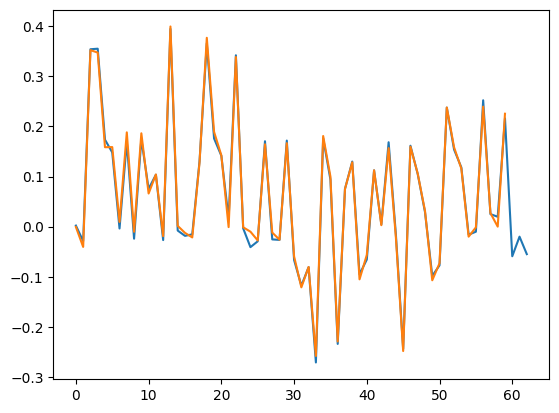

In [96]:
plt.plot(params.mean(-1))
plt.plot(A1_mean)

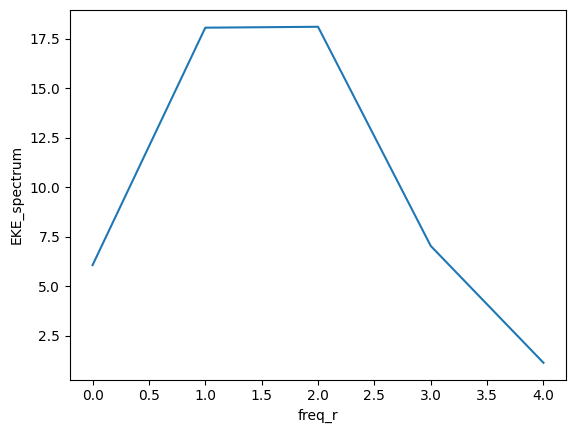

In [102]:
metrics['EKE_spectrum'][0][20][1].plot()